# Reinforcement Learning with Function Approximation

Author: Ramy Ghorayeb
    
Date: December 2018

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from lqg1d import LQG1D

## 1. On-Policy Reinforcement Learning with Parametric Policy

### 1.1 Trajectory-based formulation and REINFORCE

In [2]:
def REINFORCE(env, policy, update_rule, k_iterations, N, T, gamma):
    
    Theta = np.zeros(k_iterations)
    Theta[0] = policy.theta
    grad_J = np.zeros(N)
    
    for k in range(1,k_iterations):
        for n in range(N):
            S,A,R = simulation(env, policy, T)
            grad_J[n] = grad_discounted_reward(policy, S, A, R, gamma)
        grad_J_est = np.mean(grad_J)
        theta = Theta[k-1] + update_rule.fn(k-1,grad_J_est)
        Theta[k] = theta
        policy.new_theta(theta)
        
    return Theta
    
def simulation(env, policy, T):
    A,S,R = np.zeros(T),np.zeros(T),np.zeros(T)
    env.reset()
    S[0] = env.state
    for t in range(T-1):
        A[t] = policy.action(env.state[0])
        next_state, R[t], boolean, array = env.step(A[t])
        S[t+1] = next_state[0]
    A[T-1] = policy.action(env.state)
    last_state, R[T-1], boolean, array = env.step(A[t]) 
        
    return S,A,R

def discounted_reward(rewards,gamma):
    reward = 0
    for r in rewards:
        reward = (reward + r)*gamma
    reward = reward/gamma
    return reward

def grad_discounted_reward(policy, S, A, R, gamma):
    T = len(R)
    grad_J = 0
    for t in range(T):
        grad_theta, grad_sigma = policy.gradient(A[t], S[t])
        grad_J += grad_theta
    grad_J = grad_J * discounted_reward(R, gamma)
    return grad_J

In [262]:
def REINFORCE(env, policy, update_rule, k_iterations, N, T, gamma):
    
    Theta = np.zeros(k_iterations)
    Theta[0] = policy.theta
    grad_J = np.zeros(N)
    
    for k in range(1,k_iterations):
        for n in range(N):
            S,A,R = simulation(env, policy, T)
            grad_J[n] = grad_discounted_reward(policy, S, A, R, gamma)
        grad_J_est = np.mean(grad_J)
        theta = Theta[k-1] + update_rule.fn(k-1,grad_J_est)
        Theta[k] = theta
        policy.new_theta(theta)
        
    return Theta
    
def simulation(env, policy, T):
    A,S,R = np.zeros(T),np.zeros(T),np.zeros(T)
    env.reset()
    S[0] = env.state
    for t in range(T-1):
        A[t] = policy.action(env.state)
        R[t] = env.reward(S[t], A[t])
        S[t+1] = env.next_step(S[t], A[t])
    A[T-1] = policy.action(env.state)
    R[T-1] = env.reward(S[T-1], A[T-1])
        
    return S,A,R

def discounted_reward(rewards,gamma):
    reward = 0
    for r in rewards:
        reward = (reward + r)*gamma
    reward = reward/gamma
    return reward

def grad_discounted_reward(policy, S, A, R, gamma):
    T = len(R)
    grad_J = 0
    for t in range(T):
        grad_theta, grad_sigma = policy.gradient(A[t], S[t])
        grad_J += grad_theta
    grad_J = grad_J * discounted_reward(R, gamma)
    return grad_J

In [16]:
# Gaussian policy

class Gaussian(object):
    def __init__(self, sigma):
        self.theta = 1 - 2*np.random.random()
        self.sigma = sigma
    
    def action(self,s):
        a = np.random.normal(self.theta * s, self.sigma**2)
        return a
    
    def gradient(self, a, s):
        mu = self.theta * s
        grad_mu = s
        grad_theta = (a - mu)/(self.sigma**2) * s
        grad_sigma = ((a - mu)**2 - self.sigma**2)/(self.sigma**3) * grad_mu
        return grad_theta, grad_sigma
    
    def new_theta(self, theta):
        self.theta = theta

### 1.3. Gradient-based update rule

In [4]:
# standard update rule

class Standard_Update(object):
    def __init__(self, alpha):
        self.alpha = alpha

    def fn(self, t, grad_J):
        return self.alpha(t) * grad_J

### 1.4. Experiments: Linear-quadratic Gaussian regulation problem (LQG problem)

In [5]:
# LQG definition

class LQG(object):
    def __init__(self, A, B, Q, R, sigma0):
        s0 = np.random.random()*40-20
        self.state = s0
        self.A = A
        self.B = B
        self.Q = Q
        self.R = R
        self.sigma0 = sigma0
    
    def next_step(self, s, a):
        self.state = np.random.normal(self.A*s + self.B*a, self.sigma0**2)
        return self.state
    
    def reward(self, s, a):
        r = -0.5*(s*self.Q*s + a*self.R*a)
        return r
    
    def reset(self):
        self.state = np.random.random()*40-20

### Q1: Implement REINFORCE with Gaussiana policy model

The variance of $J$ is extremely high, making the algorithm very unstable. 
We could raise N but the computational power required quickly gets off limits (it is N-proportional).
One easy trick to solve that is to have a very high standard deviation but it is very restraining for the policy actions

In [340]:
# Case considered: 1-dimensional problem with standard_deviation = 0.4
# env = LQG( A=1, B=1, Q=1, R=1, sigma0=0)
env = LQG1D('random')
policy = Gaussian(sigma=0.5)
update_rule = Standard_Update(alpha = lambda t:0.005/(t+1))
theta_s = -0.6

Theta = np.zeros((10,50))
for t in range(10):
    print('iteration:',t+1)
    Theta[t] = REINFORCE(env, policy, update_rule, k_iterations=50, N=50, T=100, gamma=0.9)

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10


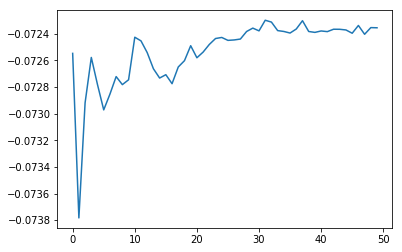

In [346]:
est_Theta = np.mean(Theta,axis=0)
plt.plot(theta_s*np.ones(50) - est_Theta)

$\alpha_t$ is the learning rate monitoring the speed of convergence. If it is too small, the convergence will be too slow. If it is too big, the convergence becomes unstable.

$N$ is the number of episodes used to estimate the gradients. The bigger the better in terms of variance minimisation. But as the computation time is proportional to N, there is a time-performance trade-off to deal with.

In [27]:
# Case considered: 1-dimensional problem with standard_deviation = 0.4
# env = LQG( A=1, B=1, Q=1, R=1, sigma0=0)
env = LQG1D('random')
policy = Gaussian(sigma=50)
update_rule = Standard_Update(alpha = lambda t:0.1)
theta_s = -0.6

Theta = np.zeros((10,50))
for t in range(5):
    print('iteration:',t+1)
    Theta[t] = REINFORCE(env, policy, update_rule, k_iterations=50, N=100, T=100, gamma=0.9)

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5


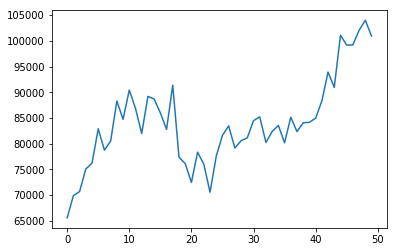

In [28]:
est_Theta = np.mean(Theta,axis=0)
plt.plot(theta_s*np.ones(50) - est_Theta)

### 1.5 Exploration in Policy Gradient

MBIE-BE and count based exploration

In [ ]:
# exploration bonus

class bonus(object):
    def __init__(self, R, N, phi):
        self.Beta= Omega(np.max(R)/(1-))
        self.N = N
        self.phi = phi
        
    def fn(self,s,a):
        b = self.Beta * math.sqrt(1/self.N(self.phi(s,a)))
        return b